In [1]:
import sys
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (month_plot, plot_acf, plot_pacf)
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
np.random.seed(0)

In [2]:
# Función de apoyo para hacer plots
def run_sequence_plot(x, y, title, xlabel="Tiempo", ylabel="Valores", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [3]:
def fft_analysis(signal):
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1) # Ajuste recta
    trend = np.arange(len(signal)) * slope + intercept #tendencia lineal para cada punto
    detrended = signal - trend # Eliminación de la tendencia lineal  componentes dominantes
    fft_values = np.fft.fft(detrended) # frecuencias correspondientes a cada componente en la FFT
    frequencies = np.fft.fftfreq(len(fft_values)) #Valores de las frecuencias
    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0] #Intensidad de las comp. freq
    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)] #Indice freq.dom
    print(f"Dominant Frequency: {dominant_frequency:.3f}")
    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    return dominant_period, positive_frequencies, magnitudes

In [10]:
# Nombres de los sensores (en el orden correcto)
sensor_names = [
    "tachometer",
    "acc_under_axial",
    "acc_under_radial",
    "acc_under_tangential",
    "acc_over_axial",
    "acc_over_radial",
    "acc_over_tangential",
    "microphone"
]

# Cargar CSV SIN header y asignar nombres
normal_12288 = pd.read_csv(
    "C:\\Users\\User\\Documents\\GitHub\\grupo1reto2\\bearing_fault_detection_reduced\\normal\\12.288.csv",
    header=None,
    names=sensor_names)

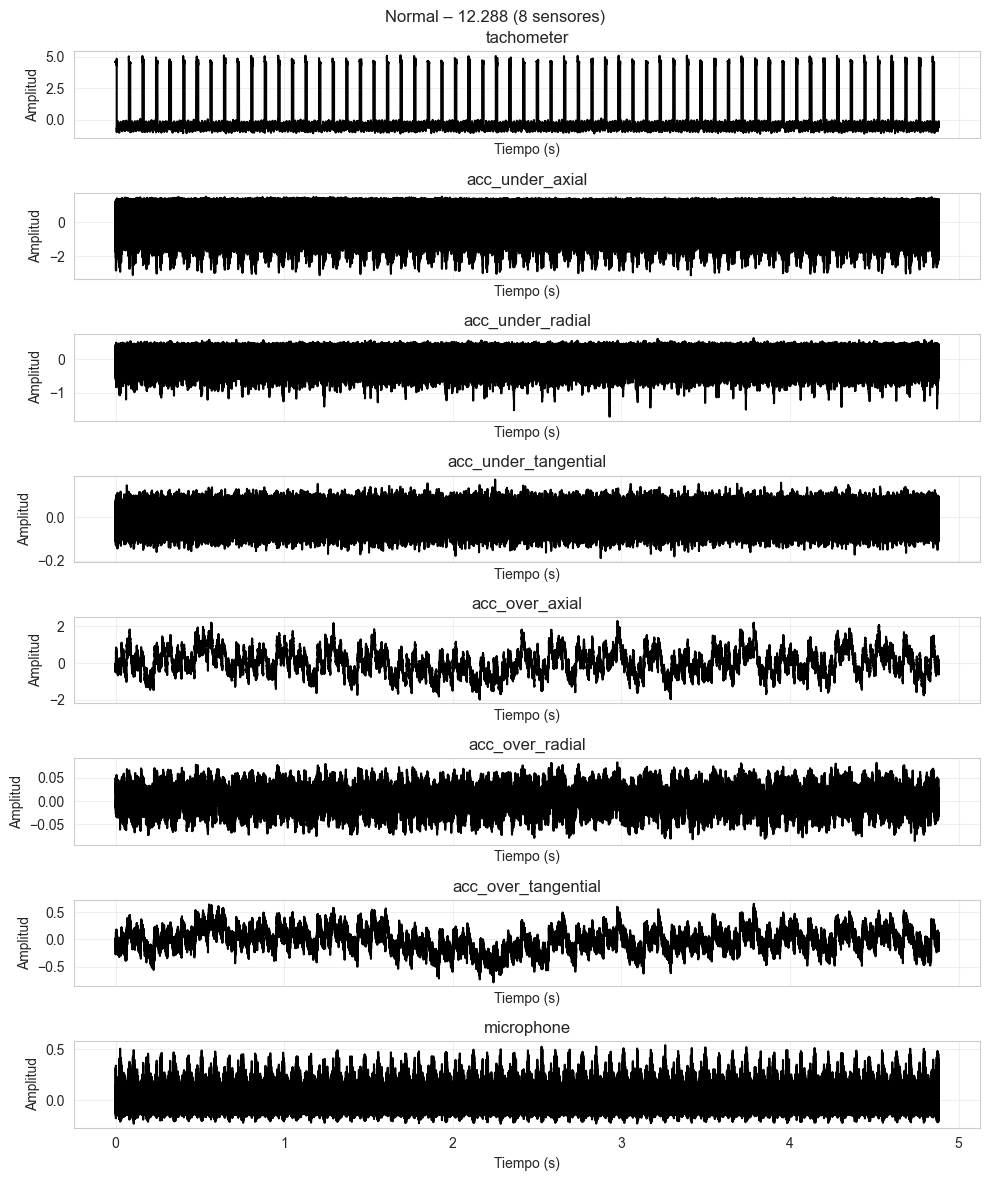

In [15]:
fs=51200

temporal = np.arange(len(normal_12288))/fs

# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(normal_12288.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, normal_12288.columns):
    run_sequence_plot(
        temporal,
        normal_12288[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Normal – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

In [12]:
# Cargar CSV SIN header y asignar nombres
hor_misalig_05 = pd.read_csv(
    "C:\\Users\\User\\Documents\\GitHub\\grupo1reto2\\bearing_fault_detection_reduced\\horizontal-misalignment\\0.5mm\\12.288.csv",
    header=None,
    names=sensor_names)

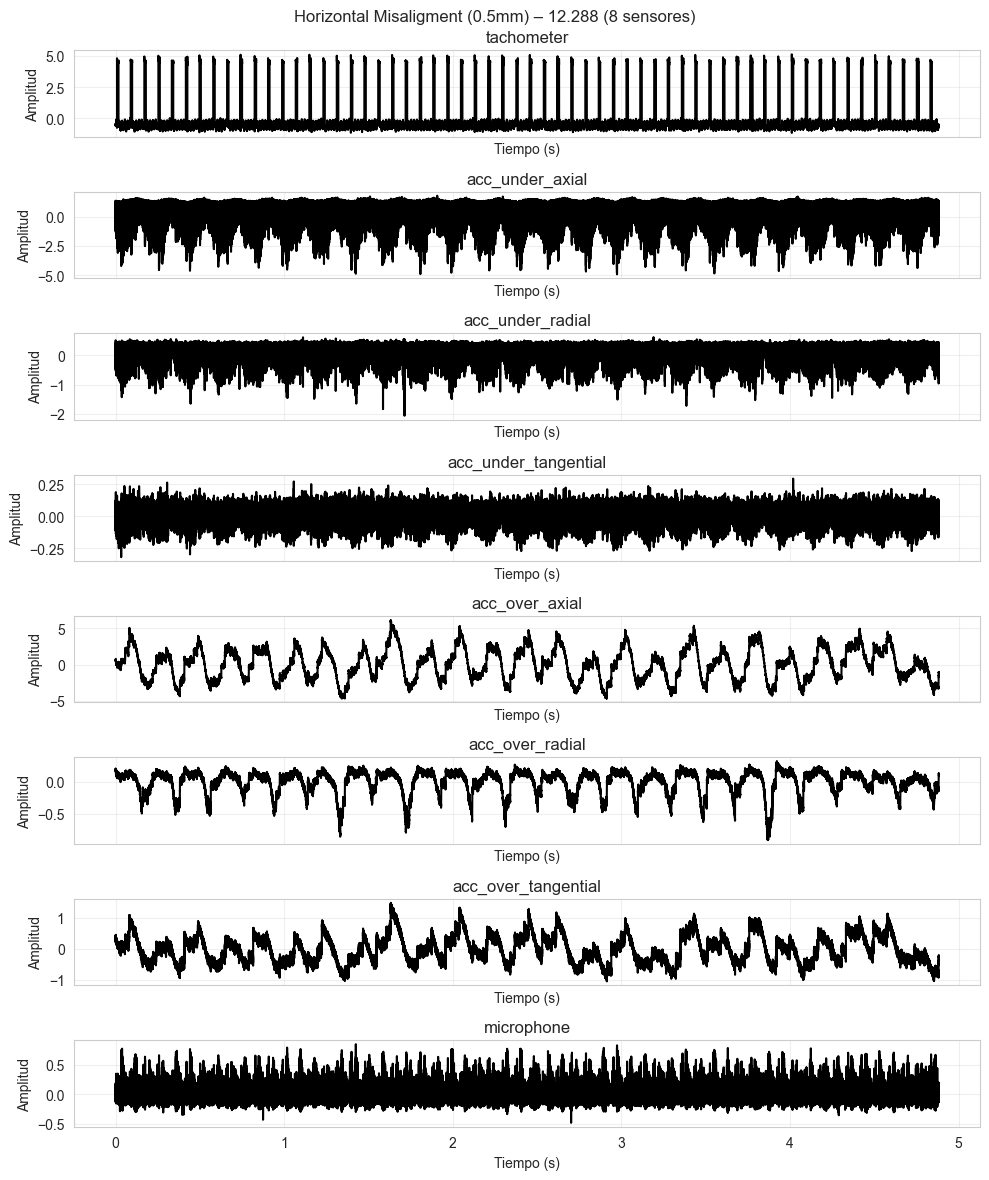

In [18]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(hor_misalig_05.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, hor_misalig_05.columns):
    run_sequence_plot(
        temporal,
        hor_misalig_05[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Horizontal Misaligment (0.5mm) – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal IMBALANCE superpuesta
    ax.plot(
        temporal,
        hor_misalig_05[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Horizontal Aligment 0.5mm"])

fig.suptitle("Comparación Normal vs Horizontal Aligment (0.5mm) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()